## Notebook Description: Model Predictions on Documents

This Jupyter notebook demonstrates the evaluation and visualization of trained segmentation models on document datasets. The notebook:

**Purpose**: Tests and visualizes predictions from pre-trained segmentation models (LUNet and UNet) on document images.

**Key Features**:
- Loads pre-trained models from checkpoints for different datasets (UTP and splitAB1)
- Supports both from-scratch and fine-tuned model variants
- Generates predictions on test datasets and compares them with ground truth masks
- Provides side-by-side visualization of original images, ground truth masks, and model predictions

**Workflow**:
1. Configures dataset parameters and model paths based on dataset type
2. Loads the appropriate pre-trained model (LUNet or UNet) with specified epochs
3. Processes test data and generates predictions
4. Visualizes results comparing original images, ground truth, and predictions

**Datasets**: Works with UTP and splitAB1 document segmentation datasets, with different output channel configurations (7 channels for UTP, 4 for splitAB1).


In [1]:
# %%
import os
from sys import path
path.append('..')
from Modules.Dataset import generate_dataset

# %%
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from Modules.Dataset import generate_dataset
from Modules.Architecture import generate_model
from Modules.Visualization import (
    visualize_mask,
    visualize_image_and_mask,
)
from Modules.ModelXAI import generate_XAI_model
# %%
dataset_type='UTP'
dataset_type='splitAB1'

base_dir: str = f"../datasets/{dataset_type}"
device = 'cpu'
device = 'cuda:0'

model_type = 'lunet'
MODEL_TAGS = ["from_scratch_models", "finetuned_models_minloss"]
model_tag = MODEL_TAGS[0] if dataset_type == 'UTP' else MODEL_TAGS[1]

OUT_CHANNELS = 7 if dataset_type == 'UTP' else 4

# Dataloader
if dataset_type == 'splitAB1':
    _, _, test_loader = generate_dataset(
        dataset_type=dataset_type,
        base_dir=base_dir,
        **{
            "train_folder": "training-40",
            "validation_folder": "validation",
            "test_folder": "test",
        }
    )
else:
    _, _, test_loader = generate_dataset(
        dataset_type=dataset_type,
        base_dir=base_dir,
        **{
            "train_folder": "Training",
            "validation_folder": "Validation",
            "test_folder": "Test",
        }
    )




UTP_EPOCHS_DICT = {
    "lunet": {MODEL_TAGS[0]: 84, MODEL_TAGS[1]: 61},
    "unet": {MODEL_TAGS[0]: 85, MODEL_TAGS[1]: 43},
}


CB55_EPOCHS_DICT = {
    "lunet": {MODEL_TAGS[0]: 108, MODEL_TAGS[1]: 40},
    "unet": {MODEL_TAGS[0]: 60, MODEL_TAGS[1]: 87},
}



if dataset_type == 'UTP':
    models_path = f"../models/{dataset_type}/{model_type}/{model_tag}"
    model_name = f"model{UTP_EPOCHS_DICT[model_type][model_tag]}.pt"
else:
    models_path = f"../models/{dataset_type}/{model_type}/{model_tag}"
    model_name = f"model{CB55_EPOCHS_DICT[model_type][model_tag]}.pt"

print(f"Loading model from {models_path}")
print(f"Model name: {model_name}")


# %%
print("Loading model...")
model = generate_model(
    model_type= model_type, 
    out_channels=OUT_CHANNELS, 
    load_from_checkpoint=True,
    models_path=models_path, 
    checkpoint_name=model_name
).eval().to(device)

# Prepare model for XAI
model = generate_XAI_model(model=model, device=device)

/mnt/backup/SegClarity/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


the number of image/label in the train:  1
the number of image/label in the validation:  1
the number of image/label in the test:  5
Loading model from ../models/splitAB1/lunet/finetuned_models_minloss
Model name: model40.pt
Loading model...
../models/splitAB1/lunet/finetuned_models_minloss/model40.pt
Model loaded successfully


In [2]:
for idx, (image_batch, mask_batch, paths) in tqdm(enumerate(test_loader)):
    image_batch = image_batch.to(device, dtype=torch.float)
    image_name = paths[0][0].split("/")[-1].split(".")[0]
    break
    

0it [00:00, ?it/s]


/mnt/backup/SegClarity/Notebooks/../Modules/Visualization/core.py:303: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/mnt/backup/SegClarity/Notebooks/../Modules/Visualization/core.py:212: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


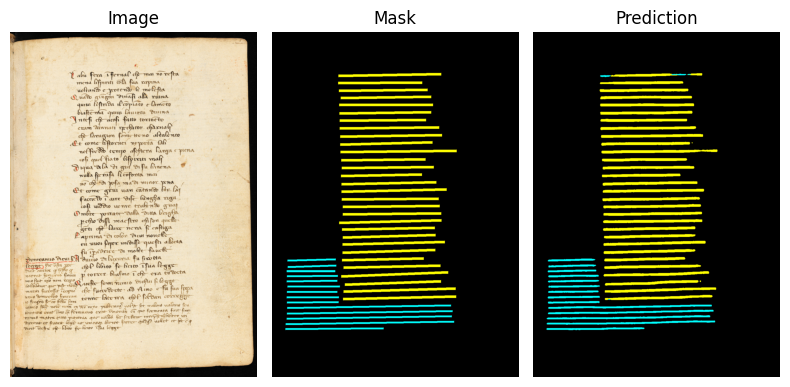

In [3]:
pred= model(image_batch).max(dim=1)[1]
fig,axes = plt.subplots(1,3,figsize=(8,6))
_ = visualize_image_and_mask(image_batch.squeeze().detach().cpu(),mask_batch.detach().cpu(), dataset_type=dataset_type,fig=fig,axes=axes)
_ = visualize_mask(pred.detach().cpu(), dataset_type=dataset_type,fig=fig,ax=axes[2]);_ =axes[2].set_title("Prediction")